In [1]:
import os
import math
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import pycocotools
from torch.utils.tensorboard import SummaryWriter

In [2]:
# if torch.cuda.is_available():  
#     device = "cuda:0" 
# else:  
#     device = "cpu" 
    
# torch.cuda.current_device()

In [3]:
# Code from Maastricht to access GPU of choice

import torch
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'


In [4]:
torch.cuda.set_device(0)
device = torch.device(f'cuda:{0}' if torch.cuda.is_available() else 'cpu')


In [5]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

## Import data

In [6]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

# Class for a customized dataset
# In this case preprocessed CEM images combined in a 3-channel RGB .jpg format
# and the corresponding mask of present lesions in a 1-channel .png format
class CustomImageDataset(Dataset):
    def __init__(self, root, annotations_file, img_dir, mask_dir, transform=None, target_transform=None):
        # Read the .csv file with all the information
        self.img_labels = pd.read_csv(os.path.join(root, annotations_file))
        # Define the directories of the images and masks
        self.img_dir = os.path.join(root, img_dir)
        self.mask_dir = os.path.join(root, mask_dir)
        # Define whethet transformations are included
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # Return the number of cases in the dataset
        # In this set, CC and MLO of the same breast are considered different cases
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Read the image and the mask for a case from the directories
        img_path = self.img_labels.iloc[idx, 0]
        mask_path = self.img_labels.iloc[idx,6]
        img_path = img_path.replace('E:', '\\\\tsclient\E')
        mask_path = mask_path.replace('E:', '\\\\tsclient\E')
        image = read_image(img_path).float()
        mask = read_image(mask_path)

        # Resize so all images and masks have the same size
#         image = T.Resize([800,800])(image)
#         mask = T.Resize([800,800])(mask)    
#         resize_scale_x = 800/image.size()[1]
#         resize_scale_y = 800/image.size()[2]

        # Resize if necessary
        # First the smallest dimension is reduced to 400 if it is larger
        # Then the largest dimension is reduced to 650 if it is still larger
        resize_scale = 1.0
        min_size_idx = np.argmin([image.size()[1], image.size()[2]])
        
        if min_size_idx == 0 and image.size()[1] > 400 :
            resize_scale *= 400/image.size()[1]
            image = T.Resize([400, int(400*image.size()[2]/image.size()[1])])(image)
            mask = T.Resize([400, int(400*image.size()[2]/image.size()[1])], interpolation=InterpolationMode.NEAREST)(mask)
        if min_size_idx == 0 and image.size()[2] > 650 :
            resize_scale *= 650/image.size()[2]
            image = T.Resize([int(650*image.size()[1]/image.size()[2]), 650])(image)
            mask = T.Resize([int(650*image.size()[1]/image.size()[2]), 650], interpolation=InterpolationMode.NEAREST)(mask)
        
        if min_size_idx == 1 and image.size()[2] > 400 :
            resize_scale *= 400/image.size()[2]
            image = T.Resize([int(400*image.size()[1]/image.size()[2]), 400])(image)
            mask = T.Resize([int(400*image.size()[1]/image.size()[2]), 400], interpolation=InterpolationMode.NEAREST)(mask)
        if min_size_idx == 1 and image.size()[1] > 650 :
            resize_scale *= 650/image.size()[1]
            image = T.Resize([650, int(650*image.size()[2]/image.size()[1])])(image)
            mask = T.Resize([650, int(650*image.size()[2]/image.size()[1])], interpolation=InterpolationMode.NEAREST)(mask)
            
#         # Normalize image with mean and standard deviation per channel
#         mean = torch.mean(image, dim=(1,2))
#         stdev = torch.std(image, dim=(1,2))
#         image = T.Normalize(mean, stdev)(image)
        
        # Rescale to [0,1] range per channel
        for dim in range(3) :
            image[dim] -= torch.min(image[dim])
            image[dim] /= torch.max(image[dim])  
        
        # Create separate channel in mask for each lesion
        mask_out = np.zeros((torch.max(mask).item(), mask.shape[-2], mask.shape[-1]))
        for lesion_idx in range(torch.max(mask).item()) :
#             mask_out[lesion_idx][mask[0]==lesion_idx+1] = 1  
            mask_out[lesion_idx][mask[0]>0] = 1 # alternative for wrong masks with only one lesion
        
        # Read the location of the lesion bounding box from the .csv file
        xmin = self.img_labels.iloc[idx, 1]
        xmax = self.img_labels.iloc[idx, 2]
        ymin = self.img_labels.iloc[idx, 3]
        ymax = self.img_labels.iloc[idx, 4]
        boxes = [[ymin*resize_scale, xmin*resize_scale, ymax*resize_scale, xmax*resize_scale]]
        # Read the label of the lesion from the .csv file
        labels = self.img_labels.iloc[idx, 5] # Set label of 1 for benign and 2 for malignant
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        labels = torch.tensor([labels])
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        mask_out = torch.from_numpy(mask_out)
        mask_out = mask_out.to(torch.uint8)
        
        iscrowd = torch.zeros((2,), dtype=torch.int64)
        
        # Apply transformations if defined
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)  
            
        target = {}
        target["image_id"] = image_id
        target["masks"] = mask_out
        target["boxes"] = boxes
        target["area"] = area
        target["labels"] = labels
        target["iscrowd"] = iscrowd
            
        return image, target

In [7]:
traindatadir = 'B:\\Astrid\\Preprocessed\\train_set_preprocessedcalc'
trainval_data = CustomImageDataset(traindatadir, 'annotations_train_calccluster_real_onlymal.csv', 'colored_to_jpg', 'mask_to_png')

testdatadir = 'B:\\Astrid\\Preprocessed\\test_set_preprocessedcalc'
test_data = CustomImageDataset(testdatadir, 'annotations_test_calccluster_real_onlymal.csv', 'colored_to_jpg', 'mask_to_png')

savedir = 'B:\\Astrid\\Preprocessed\\ModelsAll'

In [8]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import utils
from torch.utils.data import random_split

train_data, val_data = random_split(trainval_data, [int(np.floor(len(trainval_data)*0.8)), int(np.ceil(len(trainval_data)*0.2))], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)
val_dataloader = DataLoader(val_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)

test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)


In [9]:
len(train_data), len(val_data), len(test_data)

(180, 45, 78)

In [10]:
# For Training

train_images, train_targets = next(iter(train_dataloader))
train_image_list = list(image for image in train_images)
train_target_list = [{k: v for k, v in t.items()} for t in train_targets]

# For Testing

test_images, test_targets = next(iter(test_dataloader))
test_image_list = list(image for image in test_images)
test_target_list = [{k: v for k, v in t.items()} for t in test_targets]

In [11]:
test_target_list

[{'image_id': tensor([53]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': tensor([[215.9185, 264.5373, 284.7066, 282.3712]]),
  'area': tensor([1226.7673]),
  'labels': tensor([1]),
  'iscrowd': tensor([0, 0])},
 {'image_id': tensor([41]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 

tensor([197]) tensor([[186.0672, 306.6145, 202.8552, 316.1743]])
[256, 366, 136, 252]


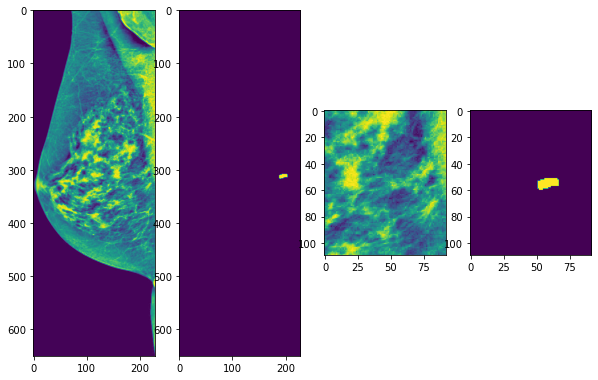

In [15]:
pat_idx = 3
print(train_targets[pat_idx]['image_id'], train_targets[pat_idx]['boxes'])

fig, ax = plt.subplots(1,4, figsize=(10,15))

ax[0].imshow(train_images[pat_idx][0])
ax[1].imshow(train_targets[pat_idx]['masks'][0])

enlarged_box = [int(train_targets[pat_idx]['boxes'][0][1])-50,
                int(train_targets[pat_idx]['boxes'][0][3])+50,
                int(train_targets[pat_idx]['boxes'][0][0])-50,                
                int(train_targets[pat_idx]['boxes'][0][2])+50]
print(enlarged_box)
ax[2].imshow(train_images[pat_idx][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])
ax[3].imshow(train_targets[pat_idx]['masks'][0, enlarged_box[0]:enlarged_box[1], enlarged_box[2]:enlarged_box[3]])

## Define model

In [16]:
import torchvision
from torchvision.models.detection import FasterRCNN, MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# backbone = torchvision.models.resnet101(pretrained=True, progress=True)
# backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                     output_size=14,
                                                     sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
# model = FasterRCNN(backbone,
#                    num_classes=3,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

# put the pieces together inside a MaskRCNN model
model = MaskRCNN(backbone,
                 num_classes=3,
                 rpn_anchor_generator=anchor_generator,
                 box_roi_pool=roi_pooler,
                 mask_roi_pool=mask_roi_pooler,
                 min_size=400,
                 max_size=650)
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)

In [17]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(400,), max_size=650, mode='bilinear')
  )
  (backbone): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
   

In [18]:
def train_one_epoch_kulum(model, optimizer, train_data_loader, val_data_loader, writer, device, epoch, print_freq, scaler=None):
    
    # Initialise training
    model.train()
    
    # Set up logger to save metrics and losses
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    # Define scheduler for learning rate in optimizer
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(train_data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    # Read the images and targets from the training data loader
    for images, targets in metric_logger.log_every(train_data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Compute the losses of the model on these training images and targets
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # Reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
           
        # Write to .tfevents
#         grid = torchvision.utils.make_grid(images)
#         writer.add_image('images', grid, 0)
#         writer.add_graph(model, images)
        
        writer.add_scalar('Loss/train', metric_logger.loss.value, epoch)
        writer.add_scalar('Loss classifier/train', metric_logger.loss_classifier.value, epoch)
        writer.add_scalar('Loss box reg/train', metric_logger.loss_box_reg.value, epoch)
        writer.add_scalar('Loss mask/train', metric_logger.loss_mask.value, epoch)
        writer.add_scalar('Loss objectness/train', metric_logger.loss_objectness.value, epoch)
        writer.add_scalar('Loss rpn box reg/train', metric_logger.loss_rpn_box_reg.value, epoch)
        
    # Set up logger to save metrics and losses of validation
    metric_logger_val = utils.MetricLogger(delimiter="  ")
    metric_logger_val.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
        
    # Read the images and targets from the validation data loader
    for images_val, targets_val in metric_logger_val.log_every(val_data_loader, print_freq, header):
        images_val = list(image.to(device) for image in images_val)
        targets_val = [{k: v.to(device) for k, v in t.items()} for t in targets_val]
        # Compute the losses of the model on these training images and targets
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict_val = model(images_val, targets_val)
            losses_val = sum(loss for loss in loss_dict_val.values())

        # Reduce losses over all GPUs for logging purposes
        loss_dict_reduced_val = utils.reduce_dict(loss_dict_val)
        losses_reduced_val = sum(loss for loss in loss_dict_reduced_val.values())

        loss_value_val = losses_reduced_val.item()
        
        metric_logger_val.update(loss=losses_reduced_val, **loss_dict_reduced_val)
        metric_logger_val.update(lr=optimizer.param_groups[0]["lr"])
        
        writer.add_scalar('Loss/val', metric_logger_val.loss.value, epoch)
        writer.add_scalar('Loss classifier/val', metric_logger_val.loss_classifier.value, epoch)
        writer.add_scalar('Loss box reg/val', metric_logger_val.loss_box_reg.value, epoch)
        writer.add_scalar('Loss mask/val', metric_logger_val.loss_mask.value, epoch)
        writer.add_scalar('Loss objectness/val', metric_logger_val.loss_objectness.value, epoch)
        writer.add_scalar('Loss rpn box reg/val', metric_logger_val.loss_rpn_box_reg.value, epoch)

    return metric_logger, metric_logger_val

def early_stopping_kulum(prev_loss, curr_loss, num_epochs) :
    
    if curr_loss > prev_loss :
        return num_epochs + 1
    else :
        return 0


In [19]:
from engine import train_one_epoch, evaluate

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# model_writer = SummaryWriter('\\\\tsclient\\E\\runs\smallexpsynthetic')
model_writer = SummaryWriter('B:\\Astrid\\Preprocessed\\runs\\12_tryorig_onlymal')

# let's train it for 10 epochs
num_epochs = 50
min_val_loss = 0.0
stop_epoch = 0

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations   
    epoch_loss, epoch_loss_val = train_one_epoch_kulum(model, optimizer, train_dataloader, val_dataloader, model_writer, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, val_dataloader, device=device)
    
#     torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'loss': loss,
#                 'loss_classifier': loss_classifier,
#                 'loss_box_reg': loss_box_reg,
#                 'loss_mask': loss_mask,
#                 'loss_objectness': loss_objectness,
#                 'loss_rpn_box': loss_rpn_box
#                 }, savedir)
    
    if epoch % 10 == 0 :
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                    }, os.path.join(savedir, 'model12_tryorig_onlymal_'+str(epoch)+'.pth'))
        
model_writer.close()

C:\Users\P70074720\.conda\envs\pytorch36\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [ 0/45]  eta: 0:07:19  lr: 0.000119  loss: 3.9813 (3.9813)  loss_classifier: 1.0534 (1.0534)  loss_box_reg: 0.0005 (0.0005)  loss_mask: 2.2274 (2.2274)  loss_objectness: 0.6918 (0.6918)  loss_rpn_box_reg: 0.0082 (0.0082)  time: 9.7659  data: 1.1710  max mem: 3184
Epoch: [0]  [10/45]  eta: 0:01:14  lr: 0.001254  loss: 3.6172 (3.3721)  loss_classifier: 0.6198 (0.5998)  loss_box_reg: 0.0060 (0.0086)  loss_mask: 2.1025 (2.1111)  loss_objectness: 0.6617 (0.6458)  loss_rpn_box_reg: 0.0060 (0.0067)  time: 2.1392  data: 1.0004  max mem: 3968
Epoch: [0]  [20/45]  eta: 0:00:43  lr: 0.002389  loss: 1.9314 (2.4984)  loss_classifier: 0.0683 (0.3326)  loss_box_reg: 0.0050 (0.0102)  loss_mask: 1.3838 (1.6465)  loss_objectness: 0.4971 (0.5027)  loss_rpn_box_reg: 0.0053 (0.0062)  time: 1.3315  data: 0.9477  max mem: 3968
Epoch: [0]  [30/45]  eta: 0:00:24  lr: 0.003524  loss: 1.1465 (1.9994)  loss_classifier: 0.0294 (0.2365)  loss_box_reg: 0.0051 (0.0095)  loss_mask: 0.8622 (1.3650)  loss_ob

Epoch: [2]  [ 0/45]  eta: 0:00:55  lr: 0.005000  loss: 0.5988 (0.5988)  loss_classifier: 0.0117 (0.0117)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.5585 (0.5585)  loss_objectness: 0.0240 (0.0240)  loss_rpn_box_reg: 0.0045 (0.0045)  time: 1.2259  data: 0.8510  max mem: 5421
Epoch: [2]  [10/45]  eta: 0:00:43  lr: 0.005000  loss: 0.6498 (0.6544)  loss_classifier: 0.0165 (0.0219)  loss_box_reg: 0.0044 (0.0077)  loss_mask: 0.6115 (0.5992)  loss_objectness: 0.0208 (0.0219)  loss_rpn_box_reg: 0.0039 (0.0035)  time: 1.2566  data: 0.8832  max mem: 5421
Epoch: [2]  [20/45]  eta: 0:00:30  lr: 0.005000  loss: 0.6513 (0.6663)  loss_classifier: 0.0170 (0.0220)  loss_box_reg: 0.0048 (0.0076)  loss_mask: 0.6115 (0.6110)  loss_objectness: 0.0206 (0.0217)  loss_rpn_box_reg: 0.0038 (0.0040)  time: 1.2045  data: 0.8402  max mem: 5421
Epoch: [2]  [30/45]  eta: 0:00:17  lr: 0.005000  loss: 0.6729 (0.6686)  loss_classifier: 0.0181 (0.0235)  loss_box_reg: 0.0048 (0.0091)  loss_mask: 0.6141 (0.6101)  loss_ob

Epoch: [4]  [ 0/45]  eta: 0:00:50  lr: 0.000500  loss: 0.5240 (0.5240)  loss_classifier: 0.0125 (0.0125)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.4881 (0.4881)  loss_objectness: 0.0191 (0.0191)  loss_rpn_box_reg: 0.0042 (0.0042)  time: 1.1229  data: 0.6879  max mem: 5432
Epoch: [4]  [10/45]  eta: 0:00:44  lr: 0.000500  loss: 0.6302 (0.6085)  loss_classifier: 0.0264 (0.0272)  loss_box_reg: 0.0114 (0.0127)  loss_mask: 0.5531 (0.5454)  loss_objectness: 0.0188 (0.0197)  loss_rpn_box_reg: 0.0030 (0.0033)  time: 1.2774  data: 0.8930  max mem: 5432
Epoch: [4]  [20/45]  eta: 0:00:30  lr: 0.000500  loss: 0.6346 (0.6227)  loss_classifier: 0.0218 (0.0241)  loss_box_reg: 0.0092 (0.0099)  loss_mask: 0.5633 (0.5641)  loss_objectness: 0.0201 (0.0210)  loss_rpn_box_reg: 0.0030 (0.0035)  time: 1.2233  data: 0.8455  max mem: 5432
Epoch: [4]  [30/45]  eta: 0:00:18  lr: 0.000500  loss: 0.6346 (0.6293)  loss_classifier: 0.0210 (0.0249)  loss_box_reg: 0.0058 (0.0101)  loss_mask: 0.5790 (0.5697)  loss_ob

Epoch: [6]  [ 0/45]  eta: 0:00:50  lr: 0.000050  loss: 0.5738 (0.5738)  loss_classifier: 0.0147 (0.0147)  loss_box_reg: 0.0021 (0.0021)  loss_mask: 0.5351 (0.5351)  loss_objectness: 0.0183 (0.0183)  loss_rpn_box_reg: 0.0036 (0.0036)  time: 1.1219  data: 0.7289  max mem: 5608
Epoch: [6]  [10/45]  eta: 0:00:41  lr: 0.000050  loss: 0.5943 (0.6005)  loss_classifier: 0.0183 (0.0204)  loss_box_reg: 0.0032 (0.0056)  loss_mask: 0.5408 (0.5505)  loss_objectness: 0.0200 (0.0209)  loss_rpn_box_reg: 0.0034 (0.0031)  time: 1.1934  data: 0.8166  max mem: 5608
Epoch: [6]  [20/45]  eta: 0:00:29  lr: 0.000050  loss: 0.6221 (0.6145)  loss_classifier: 0.0183 (0.0237)  loss_box_reg: 0.0037 (0.0080)  loss_mask: 0.5614 (0.5576)  loss_objectness: 0.0200 (0.0215)  loss_rpn_box_reg: 0.0035 (0.0036)  time: 1.1847  data: 0.8096  max mem: 5608
Epoch: [6]  [30/45]  eta: 0:00:17  lr: 0.000050  loss: 0.6306 (0.6247)  loss_classifier: 0.0250 (0.0261)  loss_box_reg: 0.0104 (0.0104)  loss_mask: 0.5738 (0.5627)  loss_ob

Epoch: [8]  [ 0/45]  eta: 0:00:53  lr: 0.000050  loss: 0.6927 (0.6927)  loss_classifier: 0.0186 (0.0186)  loss_box_reg: 0.0060 (0.0060)  loss_mask: 0.6474 (0.6474)  loss_objectness: 0.0171 (0.0171)  loss_rpn_box_reg: 0.0036 (0.0036)  time: 1.1799  data: 0.8209  max mem: 5608
Epoch: [8]  [10/45]  eta: 0:00:46  lr: 0.000050  loss: 0.6029 (0.6205)  loss_classifier: 0.0216 (0.0250)  loss_box_reg: 0.0075 (0.0103)  loss_mask: 0.5505 (0.5608)  loss_objectness: 0.0199 (0.0209)  loss_rpn_box_reg: 0.0033 (0.0035)  time: 1.3352  data: 0.9607  max mem: 5608
Epoch: [8]  [20/45]  eta: 0:00:39  lr: 0.000050  loss: 0.6029 (0.6144)  loss_classifier: 0.0198 (0.0248)  loss_box_reg: 0.0075 (0.0096)  loss_mask: 0.5505 (0.5558)  loss_objectness: 0.0199 (0.0208)  loss_rpn_box_reg: 0.0033 (0.0035)  time: 1.5864  data: 1.2071  max mem: 5608
Epoch: [8]  [30/45]  eta: 0:00:21  lr: 0.000050  loss: 0.6062 (0.6124)  loss_classifier: 0.0170 (0.0250)  loss_box_reg: 0.0037 (0.0098)  loss_mask: 0.5369 (0.5535)  loss_ob

Epoch: [10]  [ 0/45]  eta: 0:00:43  lr: 0.000005  loss: 0.6462 (0.6462)  loss_classifier: 0.0264 (0.0264)  loss_box_reg: 0.0118 (0.0118)  loss_mask: 0.5775 (0.5775)  loss_objectness: 0.0269 (0.0269)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 0.9690  data: 0.6360  max mem: 5608
Epoch: [10]  [10/45]  eta: 0:00:45  lr: 0.000005  loss: 0.6462 (0.6321)  loss_classifier: 0.0189 (0.0200)  loss_box_reg: 0.0039 (0.0051)  loss_mask: 0.5775 (0.5826)  loss_objectness: 0.0211 (0.0209)  loss_rpn_box_reg: 0.0035 (0.0036)  time: 1.3008  data: 0.9141  max mem: 5608
Epoch: [10]  [20/45]  eta: 0:00:31  lr: 0.000005  loss: 0.5933 (0.6156)  loss_classifier: 0.0189 (0.0217)  loss_box_reg: 0.0039 (0.0066)  loss_mask: 0.5446 (0.5634)  loss_objectness: 0.0193 (0.0204)  loss_rpn_box_reg: 0.0032 (0.0035)  time: 1.2645  data: 0.8821  max mem: 5608
Epoch: [10]  [30/45]  eta: 0:00:18  lr: 0.000005  loss: 0.6057 (0.6210)  loss_classifier: 0.0214 (0.0242)  loss_box_reg: 0.0073 (0.0088)  loss_mask: 0.5471 (0.5643)  los

Epoch: [12]  [ 0/45]  eta: 0:00:56  lr: 0.000001  loss: 0.5864 (0.5864)  loss_classifier: 0.0202 (0.0202)  loss_box_reg: 0.0065 (0.0065)  loss_mask: 0.5349 (0.5349)  loss_objectness: 0.0211 (0.0211)  loss_rpn_box_reg: 0.0037 (0.0037)  time: 1.2599  data: 0.8619  max mem: 5608
Epoch: [12]  [10/45]  eta: 0:00:44  lr: 0.000001  loss: 0.5913 (0.6001)  loss_classifier: 0.0163 (0.0190)  loss_box_reg: 0.0031 (0.0067)  loss_mask: 0.5523 (0.5510)  loss_objectness: 0.0183 (0.0192)  loss_rpn_box_reg: 0.0037 (0.0041)  time: 1.2813  data: 0.9066  max mem: 5608
Epoch: [12]  [20/45]  eta: 0:00:30  lr: 0.000001  loss: 0.6071 (0.6073)  loss_classifier: 0.0168 (0.0218)  loss_box_reg: 0.0054 (0.0088)  loss_mask: 0.5539 (0.5526)  loss_objectness: 0.0202 (0.0201)  loss_rpn_box_reg: 0.0038 (0.0040)  time: 1.2038  data: 0.8325  max mem: 5608
Epoch: [12]  [30/45]  eta: 0:00:17  lr: 0.000001  loss: 0.6071 (0.6022)  loss_classifier: 0.0179 (0.0216)  loss_box_reg: 0.0061 (0.0081)  loss_mask: 0.5529 (0.5482)  los

Epoch: [14]  [ 0/45]  eta: 0:00:46  lr: 0.000001  loss: 0.6690 (0.6690)  loss_classifier: 0.0299 (0.0299)  loss_box_reg: 0.0129 (0.0129)  loss_mask: 0.5991 (0.5991)  loss_objectness: 0.0244 (0.0244)  loss_rpn_box_reg: 0.0026 (0.0026)  time: 1.0360  data: 0.6600  max mem: 5608
Epoch: [14]  [10/45]  eta: 0:00:42  lr: 0.000001  loss: 0.6384 (0.6341)  loss_classifier: 0.0198 (0.0283)  loss_box_reg: 0.0060 (0.0120)  loss_mask: 0.5405 (0.5694)  loss_objectness: 0.0190 (0.0211)  loss_rpn_box_reg: 0.0034 (0.0032)  time: 1.2071  data: 0.8347  max mem: 5608
Epoch: [14]  [20/45]  eta: 0:00:29  lr: 0.000001  loss: 0.5988 (0.6161)  loss_classifier: 0.0182 (0.0243)  loss_box_reg: 0.0041 (0.0091)  loss_mask: 0.5405 (0.5584)  loss_objectness: 0.0188 (0.0206)  loss_rpn_box_reg: 0.0033 (0.0036)  time: 1.1850  data: 0.8135  max mem: 5608
Epoch: [14]  [30/45]  eta: 0:00:17  lr: 0.000001  loss: 0.5969 (0.6072)  loss_classifier: 0.0216 (0.0267)  loss_box_reg: 0.0080 (0.0105)  loss_mask: 0.5310 (0.5454)  los

Epoch: [16]  [ 0/45]  eta: 0:00:52  lr: 0.000000  loss: 0.6984 (0.6984)  loss_classifier: 0.0301 (0.0301)  loss_box_reg: 0.0168 (0.0168)  loss_mask: 0.6264 (0.6264)  loss_objectness: 0.0217 (0.0217)  loss_rpn_box_reg: 0.0034 (0.0034)  time: 1.1689  data: 0.7619  max mem: 5608
Epoch: [16]  [10/45]  eta: 0:00:43  lr: 0.000000  loss: 0.6338 (0.6280)  loss_classifier: 0.0262 (0.0280)  loss_box_reg: 0.0110 (0.0132)  loss_mask: 0.5730 (0.5629)  loss_objectness: 0.0211 (0.0207)  loss_rpn_box_reg: 0.0033 (0.0032)  time: 1.2376  data: 0.8595  max mem: 5608
Epoch: [16]  [20/45]  eta: 0:00:30  lr: 0.000000  loss: 0.6112 (0.6140)  loss_classifier: 0.0178 (0.0240)  loss_box_reg: 0.0049 (0.0097)  loss_mask: 0.5579 (0.5560)  loss_objectness: 0.0196 (0.0207)  loss_rpn_box_reg: 0.0031 (0.0036)  time: 1.2111  data: 0.8356  max mem: 5608
Epoch: [16]  [30/45]  eta: 0:00:17  lr: 0.000000  loss: 0.5967 (0.6135)  loss_classifier: 0.0173 (0.0247)  loss_box_reg: 0.0031 (0.0101)  loss_mask: 0.5434 (0.5545)  los

Epoch: [18]  [ 0/45]  eta: 0:00:52  lr: 0.000000  loss: 0.6745 (0.6745)  loss_classifier: 0.0325 (0.0325)  loss_box_reg: 0.0189 (0.0189)  loss_mask: 0.5991 (0.5991)  loss_objectness: 0.0214 (0.0214)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 1.1770  data: 0.7780  max mem: 5608
Epoch: [18]  [10/45]  eta: 0:00:43  lr: 0.000000  loss: 0.5985 (0.6170)  loss_classifier: 0.0220 (0.0225)  loss_box_reg: 0.0056 (0.0080)  loss_mask: 0.5597 (0.5623)  loss_objectness: 0.0198 (0.0208)  loss_rpn_box_reg: 0.0030 (0.0034)  time: 1.2290  data: 0.8494  max mem: 5608
Epoch: [18]  [20/45]  eta: 0:00:29  lr: 0.000000  loss: 0.6085 (0.6145)  loss_classifier: 0.0240 (0.0283)  loss_box_reg: 0.0073 (0.0126)  loss_mask: 0.5434 (0.5487)  loss_objectness: 0.0198 (0.0213)  loss_rpn_box_reg: 0.0031 (0.0036)  time: 1.1987  data: 0.8274  max mem: 5608
Epoch: [18]  [30/45]  eta: 0:00:17  lr: 0.000000  loss: 0.5956 (0.6052)  loss_classifier: 0.0240 (0.0267)  loss_box_reg: 0.0113 (0.0117)  loss_mask: 0.5172 (0.5422)  los

Epoch: [20]  [ 0/45]  eta: 0:00:53  lr: 0.000000  loss: 0.6313 (0.6313)  loss_classifier: 0.0202 (0.0202)  loss_box_reg: 0.0031 (0.0031)  loss_mask: 0.5803 (0.5803)  loss_objectness: 0.0242 (0.0242)  loss_rpn_box_reg: 0.0034 (0.0034)  time: 1.1800  data: 0.7950  max mem: 5608
Epoch: [20]  [10/45]  eta: 0:00:43  lr: 0.000000  loss: 0.6245 (0.6209)  loss_classifier: 0.0208 (0.0292)  loss_box_reg: 0.0066 (0.0128)  loss_mask: 0.5394 (0.5539)  loss_objectness: 0.0214 (0.0219)  loss_rpn_box_reg: 0.0034 (0.0031)  time: 1.2544  data: 0.8730  max mem: 5608
Epoch: [20]  [20/45]  eta: 0:00:29  lr: 0.000000  loss: 0.6245 (0.6330)  loss_classifier: 0.0200 (0.0258)  loss_box_reg: 0.0068 (0.0102)  loss_mask: 0.5451 (0.5728)  loss_objectness: 0.0196 (0.0211)  loss_rpn_box_reg: 0.0032 (0.0033)  time: 1.1737  data: 0.8020  max mem: 5608
Epoch: [20]  [30/45]  eta: 0:00:17  lr: 0.000000  loss: 0.6229 (0.6316)  loss_classifier: 0.0210 (0.0247)  loss_box_reg: 0.0069 (0.0096)  loss_mask: 0.5568 (0.5732)  los

Epoch: [22]  [ 0/45]  eta: 0:00:59  lr: 0.000000  loss: 0.7452 (0.7452)  loss_classifier: 0.0264 (0.0264)  loss_box_reg: 0.0038 (0.0038)  loss_mask: 0.6842 (0.6842)  loss_objectness: 0.0270 (0.0270)  loss_rpn_box_reg: 0.0038 (0.0038)  time: 1.3210  data: 0.9419  max mem: 5608
Epoch: [22]  [10/45]  eta: 0:00:41  lr: 0.000000  loss: 0.6245 (0.6175)  loss_classifier: 0.0178 (0.0196)  loss_box_reg: 0.0039 (0.0056)  loss_mask: 0.5744 (0.5655)  loss_objectness: 0.0209 (0.0216)  loss_rpn_box_reg: 0.0045 (0.0053)  time: 1.1767  data: 0.8015  max mem: 5608
Epoch: [22]  [20/45]  eta: 0:00:29  lr: 0.000000  loss: 0.5967 (0.6053)  loss_classifier: 0.0185 (0.0232)  loss_box_reg: 0.0039 (0.0066)  loss_mask: 0.5481 (0.5498)  loss_objectness: 0.0207 (0.0213)  loss_rpn_box_reg: 0.0040 (0.0043)  time: 1.1613  data: 0.7915  max mem: 5608
Epoch: [22]  [30/45]  eta: 0:00:17  lr: 0.000000  loss: 0.6011 (0.6103)  loss_classifier: 0.0236 (0.0268)  loss_box_reg: 0.0107 (0.0100)  loss_mask: 0.5345 (0.5478)  los

Epoch: [24]  [ 0/45]  eta: 0:00:55  lr: 0.000000  loss: 0.5607 (0.5607)  loss_classifier: 0.0148 (0.0148)  loss_box_reg: 0.0023 (0.0023)  loss_mask: 0.5226 (0.5226)  loss_objectness: 0.0191 (0.0191)  loss_rpn_box_reg: 0.0018 (0.0018)  time: 1.2289  data: 0.8579  max mem: 5608
Epoch: [24]  [10/45]  eta: 0:00:41  lr: 0.000000  loss: 0.6138 (0.6135)  loss_classifier: 0.0213 (0.0255)  loss_box_reg: 0.0061 (0.0105)  loss_mask: 0.5531 (0.5526)  loss_objectness: 0.0202 (0.0213)  loss_rpn_box_reg: 0.0034 (0.0036)  time: 1.1883  data: 0.8196  max mem: 5608
Epoch: [24]  [20/45]  eta: 0:00:29  lr: 0.000000  loss: 0.6188 (0.6104)  loss_classifier: 0.0182 (0.0222)  loss_box_reg: 0.0053 (0.0076)  loss_mask: 0.5532 (0.5557)  loss_objectness: 0.0201 (0.0209)  loss_rpn_box_reg: 0.0035 (0.0039)  time: 1.1930  data: 0.8272  max mem: 5608
Epoch: [24]  [30/45]  eta: 0:00:17  lr: 0.000000  loss: 0.6189 (0.6187)  loss_classifier: 0.0166 (0.0246)  loss_box_reg: 0.0038 (0.0097)  loss_mask: 0.5532 (0.5600)  los

Epoch: [26]  [ 0/45]  eta: 0:01:03  lr: 0.000000  loss: 0.5235 (0.5235)  loss_classifier: 0.0120 (0.0120)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.4845 (0.4845)  loss_objectness: 0.0200 (0.0200)  loss_rpn_box_reg: 0.0070 (0.0070)  time: 1.4070  data: 1.0140  max mem: 5608
Epoch: [26]  [10/45]  eta: 0:00:41  lr: 0.000000  loss: 0.5749 (0.5783)  loss_classifier: 0.0182 (0.0266)  loss_box_reg: 0.0074 (0.0107)  loss_mask: 0.4873 (0.5167)  loss_objectness: 0.0200 (0.0208)  loss_rpn_box_reg: 0.0029 (0.0034)  time: 1.1764  data: 0.8054  max mem: 5608
Epoch: [26]  [20/45]  eta: 0:00:29  lr: 0.000000  loss: 0.5749 (0.5834)  loss_classifier: 0.0175 (0.0232)  loss_box_reg: 0.0037 (0.0085)  loss_mask: 0.5291 (0.5280)  loss_objectness: 0.0192 (0.0203)  loss_rpn_box_reg: 0.0029 (0.0033)  time: 1.1603  data: 0.7855  max mem: 5608
Epoch: [26]  [30/45]  eta: 0:00:17  lr: 0.000000  loss: 0.6234 (0.5987)  loss_classifier: 0.0170 (0.0242)  loss_box_reg: 0.0036 (0.0089)  loss_mask: 0.5571 (0.5414)  los

Epoch: [28]  [ 0/45]  eta: 0:01:08  lr: 0.000000  loss: 0.5485 (0.5485)  loss_classifier: 0.0520 (0.0520)  loss_box_reg: 0.0197 (0.0197)  loss_mask: 0.4531 (0.4531)  loss_objectness: 0.0218 (0.0218)  loss_rpn_box_reg: 0.0019 (0.0019)  time: 1.5140  data: 1.1189  max mem: 5608
Epoch: [28]  [10/45]  eta: 0:00:43  lr: 0.000000  loss: 0.6323 (0.6129)  loss_classifier: 0.0174 (0.0267)  loss_box_reg: 0.0031 (0.0098)  loss_mask: 0.5681 (0.5522)  loss_objectness: 0.0199 (0.0207)  loss_rpn_box_reg: 0.0031 (0.0034)  time: 1.2294  data: 0.8558  max mem: 5608
Epoch: [28]  [20/45]  eta: 0:00:30  lr: 0.000000  loss: 0.6321 (0.6143)  loss_classifier: 0.0200 (0.0296)  loss_box_reg: 0.0043 (0.0116)  loss_mask: 0.5560 (0.5473)  loss_objectness: 0.0204 (0.0218)  loss_rpn_box_reg: 0.0033 (0.0039)  time: 1.2054  data: 0.8341  max mem: 5608
Epoch: [28]  [30/45]  eta: 0:00:18  lr: 0.000000  loss: 0.5849 (0.6087)  loss_classifier: 0.0219 (0.0281)  loss_box_reg: 0.0105 (0.0119)  loss_mask: 0.5211 (0.5442)  los

Epoch: [30]  [ 0/45]  eta: 0:00:50  lr: 0.000000  loss: 0.5782 (0.5782)  loss_classifier: 0.0177 (0.0177)  loss_box_reg: 0.0101 (0.0101)  loss_mask: 0.5294 (0.5294)  loss_objectness: 0.0188 (0.0188)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 1.1140  data: 0.7600  max mem: 5608
Epoch: [30]  [10/45]  eta: 0:00:40  lr: 0.000000  loss: 0.5880 (0.5996)  loss_classifier: 0.0295 (0.0318)  loss_box_reg: 0.0128 (0.0146)  loss_mask: 0.5261 (0.5283)  loss_objectness: 0.0219 (0.0218)  loss_rpn_box_reg: 0.0034 (0.0032)  time: 1.1528  data: 0.7809  max mem: 5608
Epoch: [30]  [20/45]  eta: 0:00:29  lr: 0.000000  loss: 0.6074 (0.6226)  loss_classifier: 0.0242 (0.0275)  loss_box_reg: 0.0098 (0.0117)  loss_mask: 0.5555 (0.5585)  loss_objectness: 0.0219 (0.0216)  loss_rpn_box_reg: 0.0033 (0.0033)  time: 1.1784  data: 0.7993  max mem: 5608
Epoch: [30]  [30/45]  eta: 0:00:17  lr: 0.000000  loss: 0.6074 (0.6094)  loss_classifier: 0.0188 (0.0269)  loss_box_reg: 0.0038 (0.0114)  loss_mask: 0.5555 (0.5464)  los

Epoch: [32]  [ 0/45]  eta: 0:00:51  lr: 0.000000  loss: 0.5154 (0.5154)  loss_classifier: 0.0136 (0.0136)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.4809 (0.4809)  loss_objectness: 0.0169 (0.0169)  loss_rpn_box_reg: 0.0040 (0.0040)  time: 1.1360  data: 0.7910  max mem: 5608
Epoch: [32]  [10/45]  eta: 0:00:42  lr: 0.000000  loss: 0.6197 (0.6141)  loss_classifier: 0.0214 (0.0236)  loss_box_reg: 0.0060 (0.0078)  loss_mask: 0.5584 (0.5586)  loss_objectness: 0.0196 (0.0205)  loss_rpn_box_reg: 0.0033 (0.0036)  time: 1.2002  data: 0.8211  max mem: 5608
Epoch: [32]  [20/45]  eta: 0:00:29  lr: 0.000000  loss: 0.5986 (0.5953)  loss_classifier: 0.0211 (0.0217)  loss_box_reg: 0.0047 (0.0065)  loss_mask: 0.5404 (0.5428)  loss_objectness: 0.0200 (0.0207)  loss_rpn_box_reg: 0.0033 (0.0035)  time: 1.1821  data: 0.8085  max mem: 5608
Epoch: [32]  [30/45]  eta: 0:00:17  lr: 0.000000  loss: 0.5986 (0.6079)  loss_classifier: 0.0218 (0.0269)  loss_box_reg: 0.0061 (0.0102)  loss_mask: 0.5257 (0.5465)  los

Epoch: [34]  [ 0/45]  eta: 0:00:58  lr: 0.000000  loss: 0.6125 (0.6125)  loss_classifier: 0.0124 (0.0124)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.5740 (0.5740)  loss_objectness: 0.0215 (0.0215)  loss_rpn_box_reg: 0.0045 (0.0045)  time: 1.3000  data: 0.9309  max mem: 5608
Epoch: [34]  [10/45]  eta: 0:00:41  lr: 0.000000  loss: 0.6118 (0.6099)  loss_classifier: 0.0168 (0.0214)  loss_box_reg: 0.0036 (0.0077)  loss_mask: 0.5325 (0.5576)  loss_objectness: 0.0195 (0.0203)  loss_rpn_box_reg: 0.0026 (0.0029)  time: 1.1850  data: 0.7988  max mem: 5608
Epoch: [34]  [20/45]  eta: 0:00:29  lr: 0.000000  loss: 0.6118 (0.6157)  loss_classifier: 0.0228 (0.0234)  loss_box_reg: 0.0076 (0.0089)  loss_mask: 0.5413 (0.5591)  loss_objectness: 0.0195 (0.0209)  loss_rpn_box_reg: 0.0028 (0.0034)  time: 1.1748  data: 0.7887  max mem: 5608
Epoch: [34]  [30/45]  eta: 0:00:18  lr: 0.000000  loss: 0.6032 (0.6089)  loss_classifier: 0.0190 (0.0243)  loss_box_reg: 0.0055 (0.0092)  loss_mask: 0.5351 (0.5513)  los

Epoch: [36]  [ 0/45]  eta: 0:00:56  lr: 0.000000  loss: 0.6755 (0.6755)  loss_classifier: 0.0287 (0.0287)  loss_box_reg: 0.0123 (0.0123)  loss_mask: 0.6026 (0.6026)  loss_objectness: 0.0272 (0.0272)  loss_rpn_box_reg: 0.0047 (0.0047)  time: 1.2550  data: 0.8589  max mem: 5608
Epoch: [36]  [10/45]  eta: 0:00:39  lr: 0.000000  loss: 0.6153 (0.6425)  loss_classifier: 0.0241 (0.0310)  loss_box_reg: 0.0117 (0.0133)  loss_mask: 0.5539 (0.5724)  loss_objectness: 0.0211 (0.0220)  loss_rpn_box_reg: 0.0035 (0.0038)  time: 1.1311  data: 0.7523  max mem: 5608
Epoch: [36]  [20/45]  eta: 0:00:29  lr: 0.000000  loss: 0.6153 (0.6329)  loss_classifier: 0.0204 (0.0254)  loss_box_reg: 0.0062 (0.0091)  loss_mask: 0.5617 (0.5738)  loss_objectness: 0.0198 (0.0211)  loss_rpn_box_reg: 0.0033 (0.0035)  time: 1.1609  data: 0.7816  max mem: 5608
Epoch: [36]  [30/45]  eta: 0:00:17  lr: 0.000000  loss: 0.6192 (0.6234)  loss_classifier: 0.0187 (0.0252)  loss_box_reg: 0.0051 (0.0096)  loss_mask: 0.5596 (0.5644)  los

Epoch: [38]  [ 0/45]  eta: 0:01:06  lr: 0.000000  loss: 0.6266 (0.6266)  loss_classifier: 0.0212 (0.0212)  loss_box_reg: 0.0047 (0.0047)  loss_mask: 0.5707 (0.5707)  loss_objectness: 0.0256 (0.0256)  loss_rpn_box_reg: 0.0043 (0.0043)  time: 1.4839  data: 1.1179  max mem: 5608
Epoch: [38]  [10/45]  eta: 0:00:45  lr: 0.000000  loss: 0.6184 (0.6029)  loss_classifier: 0.0233 (0.0290)  loss_box_reg: 0.0092 (0.0129)  loss_mask: 0.5416 (0.5367)  loss_objectness: 0.0197 (0.0210)  loss_rpn_box_reg: 0.0030 (0.0033)  time: 1.2966  data: 0.9235  max mem: 5608
Epoch: [38]  [20/45]  eta: 0:00:31  lr: 0.000000  loss: 0.6183 (0.6076)  loss_classifier: 0.0190 (0.0243)  loss_box_reg: 0.0069 (0.0090)  loss_mask: 0.5569 (0.5508)  loss_objectness: 0.0189 (0.0201)  loss_rpn_box_reg: 0.0033 (0.0034)  time: 1.2331  data: 0.8582  max mem: 5608
Epoch: [38]  [30/45]  eta: 0:00:18  lr: 0.000000  loss: 0.6039 (0.6029)  loss_classifier: 0.0182 (0.0249)  loss_box_reg: 0.0069 (0.0094)  loss_mask: 0.5594 (0.5442)  los

Epoch: [40]  [ 0/45]  eta: 0:00:58  lr: 0.000000  loss: 0.6702 (0.6702)  loss_classifier: 0.0215 (0.0215)  loss_box_reg: 0.0065 (0.0065)  loss_mask: 0.6180 (0.6180)  loss_objectness: 0.0206 (0.0206)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 1.2939  data: 0.9159  max mem: 5608
Epoch: [40]  [10/45]  eta: 0:00:42  lr: 0.000000  loss: 0.6340 (0.6246)  loss_classifier: 0.0249 (0.0283)  loss_box_reg: 0.0065 (0.0106)  loss_mask: 0.5787 (0.5602)  loss_objectness: 0.0206 (0.0216)  loss_rpn_box_reg: 0.0039 (0.0040)  time: 1.2031  data: 0.8281  max mem: 5608
Epoch: [40]  [20/45]  eta: 0:00:29  lr: 0.000000  loss: 0.6309 (0.6238)  loss_classifier: 0.0245 (0.0258)  loss_box_reg: 0.0065 (0.0100)  loss_mask: 0.5724 (0.5620)  loss_objectness: 0.0205 (0.0221)  loss_rpn_box_reg: 0.0039 (0.0039)  time: 1.1828  data: 0.8077  max mem: 5608
Epoch: [40]  [30/45]  eta: 0:00:18  lr: 0.000000  loss: 0.6287 (0.6184)  loss_classifier: 0.0181 (0.0240)  loss_box_reg: 0.0047 (0.0087)  loss_mask: 0.5681 (0.5603)  los

Epoch: [42]  [ 0/45]  eta: 0:00:51  lr: 0.000000  loss: 0.6125 (0.6125)  loss_classifier: 0.0115 (0.0115)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.5628 (0.5628)  loss_objectness: 0.0292 (0.0292)  loss_rpn_box_reg: 0.0090 (0.0090)  time: 1.1460  data: 0.7830  max mem: 5608
Epoch: [42]  [10/45]  eta: 0:00:42  lr: 0.000000  loss: 0.6026 (0.5974)  loss_classifier: 0.0231 (0.0255)  loss_box_reg: 0.0042 (0.0087)  loss_mask: 0.5316 (0.5380)  loss_objectness: 0.0210 (0.0214)  loss_rpn_box_reg: 0.0036 (0.0039)  time: 1.2085  data: 0.8222  max mem: 5608
Epoch: [42]  [20/45]  eta: 0:00:30  lr: 0.000000  loss: 0.6026 (0.5989)  loss_classifier: 0.0200 (0.0249)  loss_box_reg: 0.0073 (0.0097)  loss_mask: 0.5316 (0.5404)  loss_objectness: 0.0196 (0.0204)  loss_rpn_box_reg: 0.0031 (0.0034)  time: 1.2216  data: 0.8403  max mem: 5608
Epoch: [42]  [30/45]  eta: 0:00:17  lr: 0.000000  loss: 0.6045 (0.6035)  loss_classifier: 0.0196 (0.0240)  loss_box_reg: 0.0051 (0.0091)  loss_mask: 0.5378 (0.5462)  los

Epoch: [44]  [ 0/45]  eta: 0:01:01  lr: 0.000000  loss: 0.5469 (0.5469)  loss_classifier: 0.0399 (0.0399)  loss_box_reg: 0.0113 (0.0113)  loss_mask: 0.4664 (0.4664)  loss_objectness: 0.0252 (0.0252)  loss_rpn_box_reg: 0.0040 (0.0040)  time: 1.3760  data: 0.9750  max mem: 5608
Epoch: [44]  [10/45]  eta: 0:00:42  lr: 0.000000  loss: 0.5892 (0.6090)  loss_classifier: 0.0170 (0.0196)  loss_box_reg: 0.0039 (0.0048)  loss_mask: 0.5531 (0.5598)  loss_objectness: 0.0195 (0.0209)  loss_rpn_box_reg: 0.0036 (0.0038)  time: 1.2194  data: 0.8497  max mem: 5608
Epoch: [44]  [20/45]  eta: 0:00:29  lr: 0.000000  loss: 0.6036 (0.6087)  loss_classifier: 0.0184 (0.0212)  loss_box_reg: 0.0050 (0.0066)  loss_mask: 0.5531 (0.5567)  loss_objectness: 0.0193 (0.0204)  loss_rpn_box_reg: 0.0033 (0.0038)  time: 1.1894  data: 0.8171  max mem: 5608
Epoch: [44]  [30/45]  eta: 0:00:17  lr: 0.000000  loss: 0.6029 (0.6052)  loss_classifier: 0.0219 (0.0244)  loss_box_reg: 0.0076 (0.0085)  loss_mask: 0.5356 (0.5476)  los

Epoch: [46]  [ 0/45]  eta: 0:00:49  lr: 0.000000  loss: 0.5712 (0.5712)  loss_classifier: 0.0178 (0.0178)  loss_box_reg: 0.0067 (0.0067)  loss_mask: 0.5265 (0.5265)  loss_objectness: 0.0173 (0.0173)  loss_rpn_box_reg: 0.0029 (0.0029)  time: 1.0960  data: 0.7370  max mem: 5608
Epoch: [46]  [10/45]  eta: 0:00:40  lr: 0.000000  loss: 0.6481 (0.6214)  loss_classifier: 0.0250 (0.0303)  loss_box_reg: 0.0077 (0.0132)  loss_mask: 0.5295 (0.5529)  loss_objectness: 0.0192 (0.0213)  loss_rpn_box_reg: 0.0033 (0.0036)  time: 1.1528  data: 0.7791  max mem: 5608
Epoch: [46]  [20/45]  eta: 0:00:29  lr: 0.000000  loss: 0.6023 (0.6124)  loss_classifier: 0.0237 (0.0270)  loss_box_reg: 0.0071 (0.0107)  loss_mask: 0.5418 (0.5505)  loss_objectness: 0.0192 (0.0207)  loss_rpn_box_reg: 0.0032 (0.0035)  time: 1.1970  data: 0.8139  max mem: 5608
Epoch: [46]  [30/45]  eta: 0:00:18  lr: 0.000000  loss: 0.6023 (0.6152)  loss_classifier: 0.0233 (0.0267)  loss_box_reg: 0.0083 (0.0104)  loss_mask: 0.5455 (0.5541)  los

Epoch: [48]  [ 0/45]  eta: 0:00:50  lr: 0.000000  loss: 0.6442 (0.6442)  loss_classifier: 0.0466 (0.0466)  loss_box_reg: 0.0281 (0.0281)  loss_mask: 0.5485 (0.5485)  loss_objectness: 0.0193 (0.0193)  loss_rpn_box_reg: 0.0018 (0.0018)  time: 1.1190  data: 0.7200  max mem: 5608
Epoch: [48]  [10/45]  eta: 0:00:41  lr: 0.000000  loss: 0.5962 (0.6093)  loss_classifier: 0.0150 (0.0205)  loss_box_reg: 0.0018 (0.0062)  loss_mask: 0.5485 (0.5575)  loss_objectness: 0.0206 (0.0211)  loss_rpn_box_reg: 0.0033 (0.0040)  time: 1.1718  data: 0.7847  max mem: 5608
Epoch: [48]  [20/45]  eta: 0:00:29  lr: 0.000000  loss: 0.5905 (0.6070)  loss_classifier: 0.0203 (0.0258)  loss_box_reg: 0.0056 (0.0097)  loss_mask: 0.5380 (0.5463)  loss_objectness: 0.0206 (0.0214)  loss_rpn_box_reg: 0.0033 (0.0039)  time: 1.1705  data: 0.7863  max mem: 5608
Epoch: [48]  [30/45]  eta: 0:00:17  lr: 0.000000  loss: 0.5905 (0.6044)  loss_classifier: 0.0195 (0.0252)  loss_box_reg: 0.0077 (0.0092)  loss_mask: 0.5401 (0.5452)  los

In [20]:
torch.save(model.state_dict(), os.path.join(savedir, 'model12_tryorig_onlymal_final.dict'))
torch.save(model, os.path.join(savedir, 'model12_tryorig_onlymal_final.pth'))

In [21]:
train_images_cuda = []
for te in train_images :
    train_images_cuda.append(te.to(device))
    

In [22]:
# test_images.to(device)
predictions = model(train_images_cuda)

In [23]:
predictions

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([], device='cuda:0', size=(0, 1, 650, 189))},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([], device='cuda:0', size=(0, 1, 650, 317))},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>),
  'masks': tensor([], device='cuda:0', size=(0, 1, 650, 223))},
 {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<In

In [33]:
train_targets

({'image_id': tensor([171]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'boxes': tensor([[ 20.4804, 237.6380,  40.6358, 254.8675]]),
  'area': tensor([347.2679]),
  'labels': tensor([2]),
  'iscrowd': tensor([0, 0])},
 {'image_id': tensor([195]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0,

In [40]:
## Load from checkpoint
checkpoint = torch.load(os.path.join('B:\\Astrid\\Preprocessed\\ModelsAll', 'model_testclass_30.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# loss = checkpoint['loss']

In [41]:
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(400,), max_size=650, mode='bilinear')
  )
  (backbone): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
   

In [52]:
logs[0].loss.value

losses = []
losses_class = []
losses_box_reg = []
losses_mask = []
losses_objectness = []
losses_rpn_box_reg = []
for ep in range(len(logs)) :
    losses.append(logs[ep].loss.value)
    losses_class.append(logs[ep].loss_classifier.value)
    losses_box_reg.append(logs[ep].loss_box_reg.value)
    losses_mask.append(logs[ep].loss_mask.value)
    losses_objectness.append(logs[ep].loss_objectness.value)
    losses_rpn_box_reg.append(logs[ep].loss_rpn_box_reg.value)

Text(0.5, 1.0, 'Loss_rpn_box_reg')

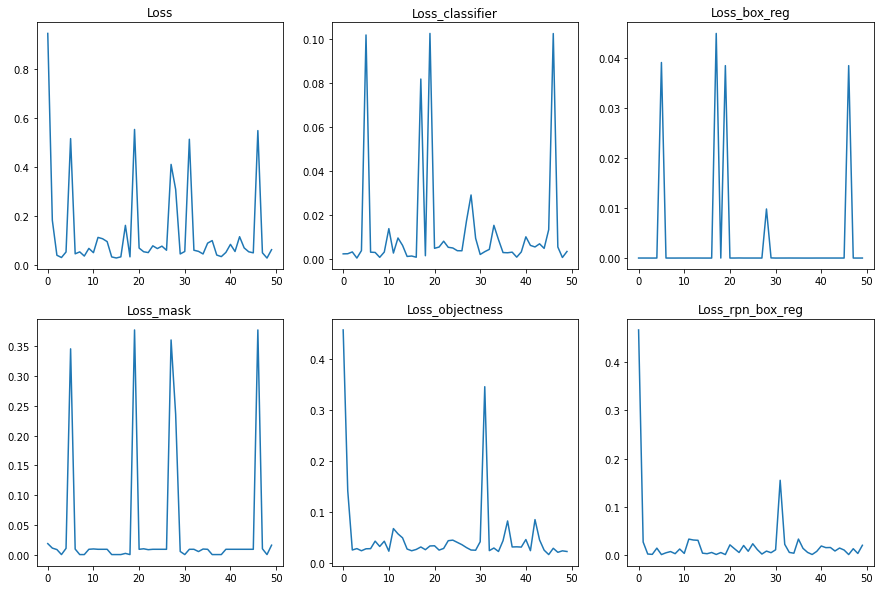

In [53]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

ax[0,0].plot(range(len(logs)),losses)
ax[0,0].set_title('Loss')
ax[0,1].plot(range(len(logs)),losses_class)
ax[0,1].set_title('Loss_classifier')
ax[0,2].plot(range(len(logs)),losses_box_reg)
ax[0,2].set_title('Loss_box_reg')
ax[1,0].plot(range(len(logs)),losses_mask)
ax[1,0].set_title('Loss_mask')
ax[1,1].plot(range(len(logs)),losses_objectness)
ax[1,1].set_title('Loss_objectness')
ax[1,2].plot(range(len(logs)),losses_rpn_box_reg)
ax[1,2].set_title('Loss_rpn_box_reg')

In [52]:
torch.max(predictions[2]['masks'])

tensor(0.0048, device='cuda:0', grad_fn=<MaxBackward1>)

In [ ]:
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             ...
#             }, PATH)

In [33]:
model = model.cpu()

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (lesion) + background
num_classes = 3  # 2 classes (lesion benign + lesion malignant) + background


# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [13]:
predictions

[{'boxes': tensor([[2.5803e+02, 2.3219e+02, 3.9800e+02, 2.9883e+02],
          [1.1064e+02, 1.4831e+02, 1.4184e+02, 1.6377e+02],
          [1.0749e+02, 1.3834e+02, 1.3233e+02, 1.7288e+02],
          [1.5622e+02, 1.9665e+02, 1.8711e+02, 2.1219e+02],
          [1.6788e+02, 1.8433e+02, 1.9201e+02, 2.2053e+02],
          [1.1911e+02, 1.3744e+02, 1.4418e+02, 1.7179e+02],
          [1.7898e+02, 1.8363e+02, 2.0447e+02, 2.1935e+02],
          [1.6970e+02, 1.9679e+02, 2.0021e+02, 2.1216e+02],
          [1.6757e+02, 1.7333e+02, 1.9111e+02, 2.0816e+02],
          [1.5799e+02, 1.8500e+02, 1.8792e+02, 2.0049e+02],
          [1.3170e+02, 1.3631e+02, 1.5699e+02, 1.7156e+02],
          [1.7809e+02, 2.9156e+02, 2.2092e+02, 3.0000e+02],
          [1.3280e+02, 1.4856e+02, 1.6463e+02, 1.6433e+02],
          [1.5361e+02, 2.9105e+02, 1.9505e+02, 3.0000e+02],
          [1.9327e+02, 1.7342e+02, 2.2308e+02, 1.8913e+02],
          [1.8191e+02, 1.9727e+02, 2.1213e+02, 2.1275e+02],
          [1.9056e+02, 1.0140e+

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [10]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [11]:
import utils as vision_utils

In [26]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
output = model(image_list, target_list)   # Returns losses and detections

# For inference
model.eval()
x = [torch.rand(3,300,400), torch.rand(3,500,400)]
predictions = model(x)           # Returns predictions

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [13]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

In [14]:
output

{'loss_classifier': tensor(0.0169, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0004, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(11.8512, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(35.1903, grad_fn=<DivBackward0>)}